In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from net import Net
from dataset import get_caption_dataset
%matplotlib inline
from PIL import image

ImportError: cannot import name 'image' from 'PIL' (/home/abinaya/anaconda3/envs/image_caption_tf/lib/python3.7/site-packages/PIL/__init__.py)

In [6]:
batch_size = 8
image_size = 224
hidden_dim = 512
num_layers = 1

data_root = "./data"
ckpt_path = "./checkpoint_resnet18/caption_200.pth"

In [7]:
# to initialize vocab
_, _, TEXT = get_caption_dataset(
    train=True,
    data_root=data_root,
    batch_size=batch_size, image_size=image_size,
    text_field=True)

loader, dataset = get_caption_dataset(
    train=False,
    data_root=data_root,
    batch_size=batch_size, image_size=image_size, shuffle=False)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net(TEXT, "resnet-18", hidden_dim, num_layers).to(device)

# load pre-trained model
state_dict = torch.load(ckpt_path)
net.load_state_dict(state_dict)

<All keys matched successfully>

In [11]:
net.eval()
cap_repr, pred_repr = list(), list()
with torch.no_grad():
    for inputs in loader:
        image   = inputs[0].to(device)
        caption = inputs[1]
        
        preds = net.sample(image)
        print(preds)
        for pred, cap in zip(preds, caption):
            cap_sent, cap_words = dataset.indices_to_string(cap, True)
            pred_sent, pred_words = dataset.indices_to_string(pred, True)
            
            cap_repr.append(cap_sent)
            pred_repr.append(pred_sent)
            
        break # run only first batch

[[  2  13   6  12 114  42  66  38  51  16   8   3  51  33   8   3  50  12
    4  28  10  18   8   3  53  13  39   8   3 213  13  75   7  13  27   7
   56   7   5  20  51  11   8   3 210  17  43  33   8   3]
 [  2  14  43  62   6  12   4  49  33  22   5  24   7  43  33  21   7   5
  121  37   8   3 119  25 272 115   8   3  13  59   5  17  10   8   3  17
   11   8   3  17  11   8   3  17  70   8   3   7  12 121]
 [  2  14   6  12   4  33  55   7  27   7   5  56   9  16  81   5  11  87
    8   3 145  12   4  28  33  22   8   3   3   3   3   3   3  46 231   8
    3   7  50  67  39  17  11   3   5  17 262   8   3  84]
 [  2  14   6  17  16   5  11   9   4  28 207   5   4 126  18   8   3  17
   60  13 272   8   3   9  37   8   3  51  58  35 132   7  13  29  17  10
    7   5   5  12   4  10  97  31  25  27   8   3  21   5]
 [  2  14 148 316  12   4 184  35  30   5  10  29   7 179 119  25  21 174
   51  11   9  10 383  31  25  45   5   4  11  18   8   3   9   4  16  23
    8   3  13  75  17   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


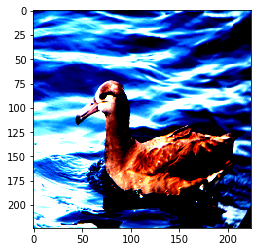

In [12]:
im = image[2]
im = im.cpu().numpy()
im = np.transpose(im,(1,2,0))
plt.imshow(im)
plt.show()

(3, 640, 480)
torch.Size([1, 3, 427, 640])
[[  2  13   6  12   4  19  20   5   4  10  24  46  77  46   4  41  22   8
    3   3   8   3   3   4  22   7   5   4  52  19  95   8   3  27   5  37
    8   3   4 257  35  29   7 167  37   7  94   7   5  37]]


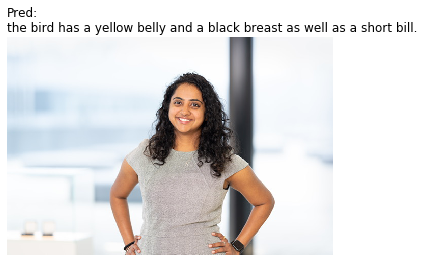

In [40]:
#own_preds = []
my_img_old = plt.imread('./assets/Abi1.JPG')
print(my_img.shape)
my_img = np.transpose(my_img_old,(2,0,1))
input_im = torch.Tensor(my_img.reshape(1, my_img.shape[0], my_img.shape[1], my_img.shape[2])).cuda()
#torch.transpose(input_im, 0,3,1,2)
print(input_im.shape)
preds = net.sample(input_im)
print(preds)
for pred in preds:
    pred_sent, pred_words = dataset.indices_to_string(pred, True)
    #own_preds.append(pred_sent)
    pred = pretty_print(pred_sent)
    
    sentence = "Pred:\n{}".format(pred)
    
    fig = plt.figure()
    plt.title(sentence, loc="left")
    plt.imshow(my_img_old)
    plt.axis("off")

In [13]:
def inverse_transform(image):
    transform = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
    image = image.clone()
    image = transform(image).mul(255).clamp_(0, 255)
    
    return image.byte().permute(1, 2, 0).cpu().numpy()

def pretty_print(string, width=100):
    new_string = ""
    for i in range(0, len(string), width):
        new_string += string[i:i+width]
        
        if i+width < len(string):
            new_string += "\n"
    return new_string

In [14]:
pred_repr

['the bird has two large wingbars that are brown.',
 'this dark colored bird has a light gray bill and breast, dark gray wings, and webbed feet.',
 'this bird has a gray neck, crown, and nape with brown secondaries and white primaries.',
 'this bird is brown and white with a long wingspan and a straight beak.',
 'this water fowl has a pattern of orange and black body, except for its wings which are white with black lines on its back and a white beak.',
 'this is a grey bird with black on its wings and a sturdy beak.',
 'the bird has a brown head with a black bill and brown coverts.',
 'this bird is almost completely light gray, with darker gray primaries and secondaries.']

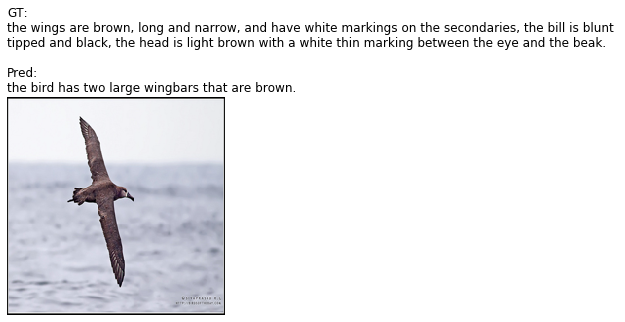

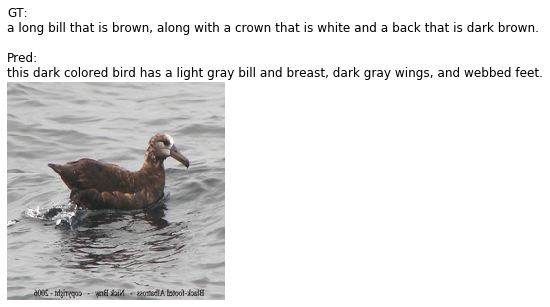

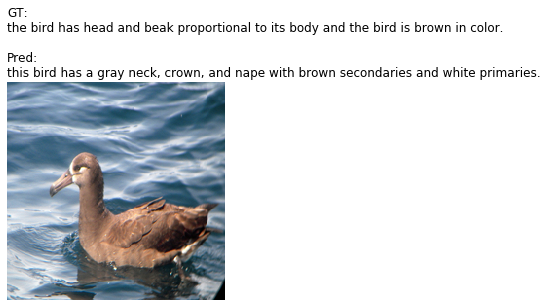

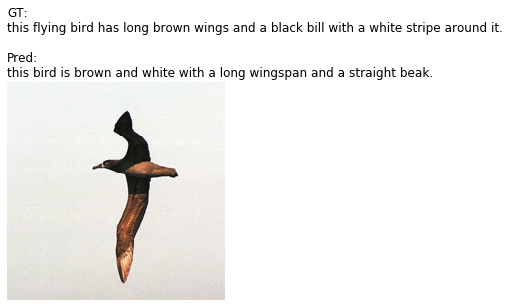

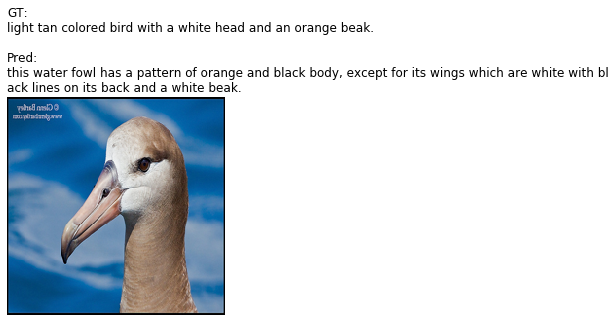

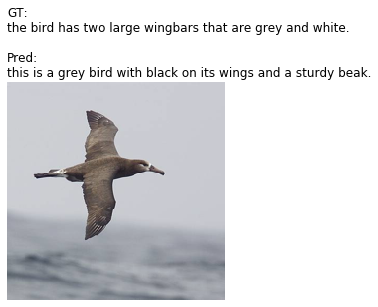

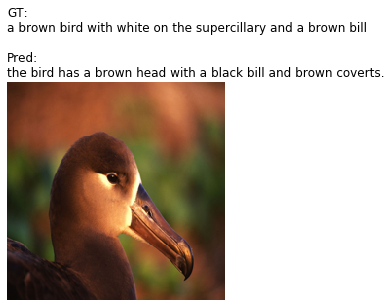

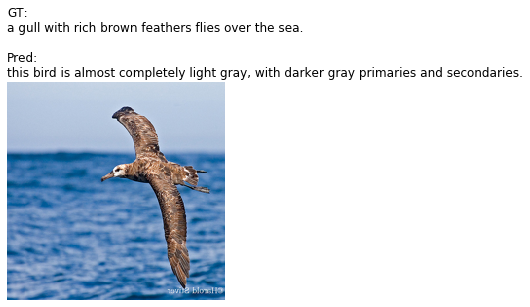

In [15]:
# visualize first batch
for i, (im, cap, pred) in enumerate(zip(image, cap_repr, pred_repr)):
    im = inverse_transform(im)
    
    cap = pretty_print(cap)
    pred = pretty_print(pred)
    
    sentence = "GT:\n{}\n\nPred:\n{}".format(cap, pred)
    
    fig = plt.figure()
    plt.title(sentence, loc="left")
    plt.imshow(im)
    plt.axis("off")